In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy

import jax
import jax.numpy as jnp
import jaxopt

from picard import amari_distance

from multiviewica_delay import (
    _apply_continuous_delays,
    generate_data,
    data_generation,
    data_generation_pierre,
    multiviewica_delay,
)

### jaxopt function

In [2]:
def _logcosh(X):
    Y = jnp.abs(X)
    return Y + jnp.log1p(jnp.exp(-2 * Y))

def optimize_unmixing_delays(
    W_list,
    delays,
    S_list,
    max_delay=10,
    noise=1,
    shared_delays=False,
    maxiter=1000,
    verbose=False,
):
    if verbose:
        start = time.time()
    m, p, _ = W_list.shape
    def loss_function(W_delays, m=m, p=p, S_list=S_list, shared_delays=shared_delays):
        W_list, delays = W_delays[:m*p**2].reshape((m, p, p)), W_delays[m*p**2:]
        if not shared_delays:
            delays = delays.reshape((m, p))
        Y_list = _apply_continuous_delays(
            S_list=S_list,
            tau_list=-delays,
            shared_delays=shared_delays,
            multiple_subjects=True,
            use_jax=True,
        )
        Y_avg = jnp.mean(Y_list, axis=0)
        loss = jnp.mean(_logcosh(Y_avg)) * p
        for W, Y in zip(W_list, Y_list):
            loss -= jnp.linalg.slogdet(W)[1]
            loss += 1 / (2 * noise) * jnp.mean((Y - Y_avg) ** 2) * p
        return loss

    init_params = jnp.concatenate([jnp.ravel(W_list), jnp.ravel(delays)])
    bounds_W_bias = (-np.ones_like(init_params) * np.inf, np.ones_like(init_params) * np.inf)
    if shared_delays:
        bounds_W_bias[0][-m:] = -max_delay
        bounds_W_bias[1][-m:] = max_delay
    else:
        bounds_W_bias[0][-m*p:] = -max_delay
        bounds_W_bias[1][-m*p:] = max_delay
    solver = jaxopt.LBFGSB(fun=loss_function, maxiter=maxiter)
    res = solver.run(init_params, bounds=bounds_W_bias)
    params, state = res
    W_list_final, delays_final = params[:m*p**2].reshape((m, p, p)), params[m*p**2:]
    if not shared_delays:
        delays_final = delays_final.reshape((m, p))
    if verbose:
        end = time.time()
        computation_time = end - start
        return W_list_final, delays_final, state, computation_time
    return W_list_final, delays_final

### parameters

In [3]:
# params
m = 5
p = 2
n = 600
max_delay = 10
shared_delays = False
random_state = 5
generation_function = "first"
if generation_function == "first":
    nb_intervals = 5
    nb_freqs = 10
    treshold = 1
    noise = 0.8
elif generation_function == "second":
    n_concat = 1
    noise = 0.01
else:
    n_bins = 10
    n_samples_per_interval = n // n_bins
    freq_level = 40
    noise = 0.2

### generate data

In [4]:
# generate sources
if generation_function == "first":
    X_list, A_list, true_tau_list, S_list, S = generate_data(
        m=m,
        p=p,
        n=n,
        nb_intervals=nb_intervals,
        nb_freqs=nb_freqs,
        treshold=treshold,
        delay=max_delay,
        noise=noise,
        random_state=random_state,
        shared_delays=shared_delays
    )
elif generation_function == "second":
    X_list, A_list, true_tau_list, S_list, S = data_generation(
        m=m,
        p=p,
        n=n,
        max_delay=max_delay,
        noise=noise,
        shared_delays=shared_delays,
        random_state=random_state,
        n_concat=n_concat,
    )
else:
    X_list, A_list, true_tau_list, S_list, S = data_generation_pierre(
        n_subjects=m,
        n_sources=p,
        n_bins=n_bins,
        n_samples_per_interval=n_samples_per_interval,
        freq_level=freq_level,
        max_delay=max_delay,
        noise=noise,
        shared_delays=shared_delays,
        random_state=random_state,
    )

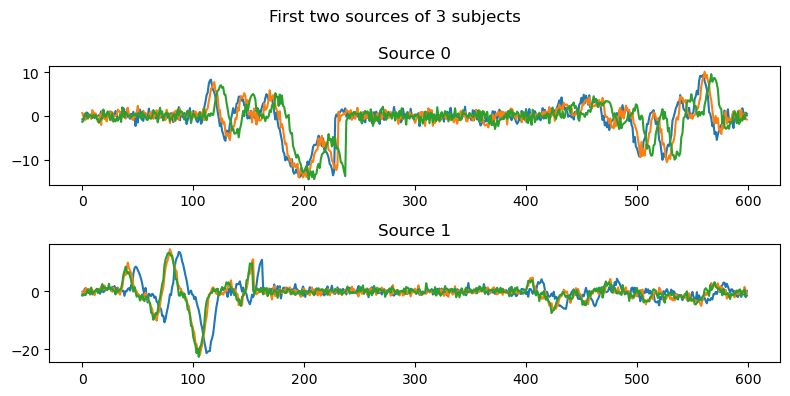

In [5]:
# plot sources of the first 2 subjects
fig, axes = plt.subplots(p, 1, figsize=(4*p, 4))

bound_min = 0
bound_max = n
for i in range(p):
    plt.subplot(p, 1, i+1)
    plt.plot(np.arange(bound_min, bound_max), S_list[:3, i, bound_min:bound_max].T)
    plt.title(f"Source {i}")
fig.suptitle("First two sources of 3 subjects")
plt.tight_layout()

### estimate unmixing and delays

In [6]:
# initialize W_list, S_list and delays
W_list_true = jnp.array([jnp.linalg.inv(A) for A in A_list])
W_list_noise = jax.random.normal(jax.random.PRNGKey(random_state), (m, p, p))
W_list_init = W_list_true + 0.1 * W_list_noise
S_list_init = jnp.array([jnp.dot(W, X) for W, X in zip(W_list_init, X_list)])
if shared_delays:
    delays_init = jnp.zeros(m)
else:
    delays_init = jnp.zeros((m, p))

In [30]:
# takes approximately 1m20 for m=5, p=2, n=600
W_lbfgsb, delays_lbfgsb, state, time_lbfgsb = optimize_unmixing_delays(
    W_list=W_list_init,
    delays=delays_init,
    S_list=S_list_init,
    noise=1,
    shared_delays=shared_delays,
    max_delay=max_delay,
    maxiter=1000,
    verbose=True,
)

# compute sources
S_lbfgsb = np.mean([np.dot(W, X) for W, X in zip(W_lbfgsb, X_list)], axis=0)

In [31]:
# MVICAD
_, W_mvicad, S_mvicad, _, delays_mvicad, _ = multiviewica_delay(
    X_list,
    init=np.array(W_list_init),
    shared_delays=shared_delays,
    max_delay=max_delay,
    random_state=random_state,
    continuous_delays=False,
)

In [32]:
# estimated sources are not necessarily in the same order as true sources
def find_order(S1, S2):
    S1 = S1 / np.linalg.norm(S1, axis=1, keepdims=True)
    S2 = S2 / np.linalg.norm(S2, axis=1, keepdims=True)
    M = np.abs(np.dot(S1, S2.T))
    try:
        _, order = scipy.optimize.linear_sum_assignment(-abs(M))
    except:
        order = np.arange(p)
    return order

if not shared_delays:
    order_lbfgsb = find_order(S, S_lbfgsb)
    delays_lbfgsb = delays_lbfgsb[:, order_lbfgsb]
    order_mvicad = find_order(S, S_mvicad)
    delays_mvicad = delays_mvicad[:, order_mvicad]

[[  0.05169056  -0.85489917]
 [  2.9091997   -8.966991  ]
 [ 10.         -10.        ]
 [ -5.0753922    6.0356197 ]
 [ -8.18715      9.089223  ]]
[[ 0  0]
 [ 3 -8]
 [10 -9]
 [-5  7]
 [-8 10]]


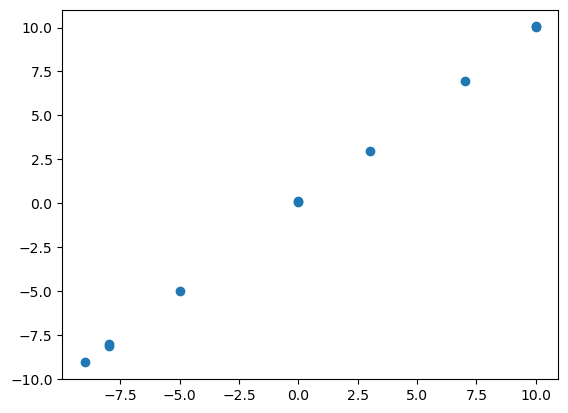

In [36]:
# compare estimated and true delays
print(delays_lbfgsb)
print(true_tau_list)

delays_lbfgsb_norm = delays_lbfgsb - np.mean(delays_lbfgsb, axis=0)
true_tau_list_norm = true_tau_list - np.mean(true_tau_list, axis=0)
plt.scatter(true_tau_list_norm, delays_lbfgsb_norm);

In [37]:
# random W
W_rand = np.random.randn(m, p, p)

In [38]:
# compare Amari distances
print("Random : ", np.mean([amari_distance(W, A) for W, A in zip(W_rand, A_list)]))
print("L-BFGS-B : ", np.mean([amari_distance(W, A) for W, A in zip(W_lbfgsb, A_list)]))
print("MVICAD : ", np.mean([amari_distance(W, A) for W, A in zip(W_mvicad, A_list)]))

Random :  0.2025970247411178
L-BFGS-B :  0.1235961523545992
MVICAD :  0.000152477463948697


### test L-BFGS without delays

In [9]:
def optimize_unmixing_alone(
    W_list,
    X_list,
    noise=1,
    maxiter=1000,
    verbose=False,
):
    if verbose:
        start = time.time()
    m, p, _ = W_list.shape

    def loss_function(W_list):
        W_list = W_list.reshape((m, p, p))
        S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
        S_avg = jnp.mean(S_list, axis=0)
        loss = jnp.mean(_logcosh(S_avg)) * p
        for W, S in zip(W_list, S_list):
            loss -= jnp.linalg.slogdet(W)[1]
            loss += 1 / (2 * noise) * jnp.mean((S - S_avg) ** 2) * p
        return loss

    init_params = jnp.ravel(W_list)
    solver = jaxopt.LBFGS(fun=loss_function, maxiter=maxiter)
    res = solver.run(init_params)
    params, state = res
    W_list_final = params.reshape((m, p, p))

    if verbose:
        end = time.time()
        computation_time = end - start
        return W_list_final, state, computation_time
    return W_list_final

In [10]:
W_lbfgs_without_delay, state_lbfgs_without_delay, time_lbfgs_without_delay = optimize_unmixing_alone(
    W_list=W_list_init,
    X_list=X_list,
    verbose=True,
)

In [11]:
print("L-BFGS without delay : ", np.mean([amari_distance(W, A) for W, A in zip(W_lbfgs_without_delay, A_list)]))

L-BFGS without delay :  0.004549907793915254


In [34]:
import pandas as pd
import os

# Example DataFrame with 2D arrays
data = {
    'Column1': [np.array([[1, 2, 3], [4, 5, 6]]), np.array([[7, 8, 9], [10, 11, 12]])],
    'Column2': [np.array([[13, 14], [15, 16]]), np.array([[17, 18], [19, 20]])]
}

df = pd.DataFrame(data)
print(df)

# Create a directory to store the serialized arrays
output_dir = 'serialized_arrays'
os.makedirs(output_dir, exist_ok=True)

for col in ['Column1', 'Column2']:
    for i, arr in enumerate(df[col]):
        np.save(os.path.join(output_dir, f"{col}_array_{i}.npy"), arr)

df.to_csv('data_with_2d_arrays.csv', index=False)

                     Column1               Column2
0     [[1, 2, 3], [4, 5, 6]]  [[13, 14], [15, 16]]
1  [[7, 8, 9], [10, 11, 12]]  [[17, 18], [19, 20]]


In [35]:
# Load the DataFrame from the CSV file
df = pd.read_csv('data_with_2d_arrays.csv')

# Function to deserialize the arrays
def deserialize_array(file_path):
    return np.load(file_path)

# Apply the deserialization function to the DataFrame's columns containing file paths
for col in ['Column1', 'Column2']:
    for i, arr in enumerate(df[col]):
        df[col][i] = deserialize_array(os.path.join(output_dir, f"{col}_array_{i}.npy"))

# Now, df contains the original 2D arrays in its cells
print(df)

                     Column1               Column2
0     [[1, 2, 3], [4, 5, 6]]  [[13, 14], [15, 16]]
1  [[7, 8, 9], [10, 11, 12]]  [[17, 18], [19, 20]]
